In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from   IPython.display import display, HTML
from collections import deque
import random
import os
import sys
import pathlib
from collections import deque
from tqdm.notebook import tqdm, trange
import datetime
from scipy import interpolate
import math

import matplotlib.ticker as mtick
import matplotlib.dates as md

from IPython.display import clear_output

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
import gpytorch
import matplotlib.dates as md

In [10]:
parent_module_path = os.path.abspath(os.path.join('..'))
if parent_module_path not in sys.path:
    sys.path.append(parent_module_path)

In [11]:
pd.set_option('display.width', 1000)
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('mode.chained_assignment', None)

# Load Data & Signals

In [12]:
trade_date = '2022-10-03'
asset_name = 'BIDU'

In [15]:
reward_fn = f'{asset_name}_{trade_date}_rewards.pkl'
all_data  = pd.read_pickle(f'../data/Rewards/{reward_fn}')
all_data  = all_data[~all_data.index.duplicated()]


In [17]:
# all_data
# all_data.buyPrice_TF.dropna()
#all_data

# GP bandits

In [18]:
from AOE.utils import verbose_print
from AOE.bandit_plots import hit_ratio_analysis, reward_distribution_analysis, regret_plots
from AOE.gp_bandit_finance import gp_bandit_finance, Wasserstein_GP_mean, Wasserstein_GP

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [19]:
strategies  = {'imbalance_1' : {'name'             : 'imbalance_1',
                                     'params'           : {'feature_name'     : 'imbalance_1'},
                                     'contextual_params': {'feature_name'     : 'imbalance_1'}},

               'MR' : {'name'             : 'MR',
                                  'params'           : {'feature_name'     : 'MR'},
                                  'contextual_params': {'feature_name'     : 'MR'}},

               'TF' : {'name'             : 'TF',
                                  'params'           : {'feature_name'     : 'TF'},
                                  'contextual_params': {'feature_name'     : 'TF'}}
              }

In [20]:
features = all_data[[s for s in all_data.columns if (('buyPrice' not in s)&('sellPrice' not in s))]]

In [24]:
# Likelihood models & non stationarity params
likelihood              = gpytorch.likelihoods.GaussianLikelihood()
size_buffer             = 30 # in terms of number of rewards to sample from
size_buffer_2           = 30 # in terms of number of rewards to sample from
size_window             = 15 # for non statonarity
bandit_params = {'size_buffer': size_buffer_2, 
                 'size_window': size_window,
                 'threshold'  : 0.0005,
                 'lambda'     : 0.1}

# Bandit objects
bandits = {'TS_NS'  : gp_bandit_finance(strategies, bandit_algo='TS_NS', likelihood=likelihood, 
                                                 bandit_params=bandit_params), 
           'UCB_NS' : gp_bandit_finance(strategies, bandit_algo='UCB_NS', likelihood=likelihood, 
                                                 bandit_params=bandit_params),
           # 'TS'  : gp_bandit_finance(strategies, bandit_algo='TS', likelihood=likelihood, size_buffer=size_buffer, size_window=size_window), 
           # 'UCB' : gp_bandit_finance(strategies, bandit_algo='UCB', likelihood=likelihood, size_buffer=size_buffer, size_window=size_window, bandit_params=0.1),
           'TS_WAS'      : gp_bandit_finance(strategies, bandit_algo='TS_WAS', likelihood=likelihood, 
                                         bandit_params=bandit_params),
           'UCB_WAS'      : gp_bandit_finance(strategies, bandit_algo='UCB_WAS', likelihood=likelihood, 
                                         bandit_params=bandit_params)}


# Other control parameters and variables

In [25]:
# variables for historical trading data
i_order                   = 0
nb_added_rewards          = {bandit_k:0 for bandit_k in bandits.keys()}
verbose_level             = 0
arrival_intensity         = 0.5
ref_price                 = 'ST'
nb_orders                 = 0

In [26]:
def init_variables(all_data, bandits):
    bandit_rewards = pd.DataFrame(index=all_data.index)
    for bandit_k in bandits.keys(): 
        bandit_rewards[bandit_k] = np.nan
    bandit_rewards['oracle'] = np.nan
    for strat in strategies.keys():
        bandit_rewards[strat] = np.nan
    
    batch_times = list(all_data.index)
    # distances   = {bandit_k:{strat: [] for strat in strategies.keys()} for bandit_k in bandits.keys()}

    bandits_fin_info = {bandit_k:pd.DataFrame(index=all_data.index) for bandit_k in bandits.keys()}
    for bandit_k in bandits.keys(): 
        bandits_fin_info[bandit_k]['execPrice'] = np.nan
        bandits_fin_info[bandit_k]['S0']        = np.nan
        bandits_fin_info[bandit_k]['ST']        = np.nan
        bandits_fin_info[bandit_k]['twapPrice'] = np.nan
        
    return bandit_rewards, bandits_fin_info, batch_times

# Trading simulation

In [27]:
def alpha(gamma, sigma, V, nu, dt):
    cosh_alpha_dt = 1 + (gamma * V * (dt*sigma)**2) / (4 * nu)
    return (1/dt) * np.arccosh(cosh_alpha_dt)

def q_star(x, q0, T, gamma, sigma, V, nu, dt):
    alpha_ = alpha(gamma, sigma, V, nu, dt)
    return q0 * np.sinh(alpha_*(T - x))/np.sinh(alpha_*T)

S0        = 100
sigma     = 5
V         = 15000000 #TransactionTape.set_index('time').traded_quantity.rolling('1h').sum().mean()
nu        = 0.1 # dollar per contract
gamma     = 10**1 #per dollar
T         = 3/60/24

timesteps = np.linspace(0, T, 100)
q0        = 100 #int(0.1 * V) # nb of shares to liquidate : 10% of total traded volume
dt        = T/100

In [ ]:
# bandit_rewards
# tmp_pnls

In [ ]:
# feature_values

************************************ Simul number: 0


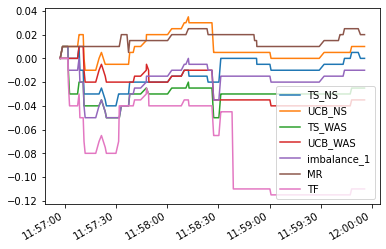

             count          mean  std  sharpe
oracle         1.0  1.650000e-01  NaN     NaN
MR             1.0  2.000000e-02  NaN     NaN
UCB_NS         1.0  1.000000e-02  NaN     NaN
TS_NS          1.0 -2.842171e-14  NaN     NaN
imbalance_1    1.0 -1.000000e-02  NaN     NaN
TS_WAS         1.0 -2.500000e-02  NaN     NaN
UCB_WAS        1.0 -3.500000e-02  NaN     NaN
TF             1.0 -1.100000e-01  NaN     NaN
TS_NS : -0.0 bps
UCB_NS : 0.84 bps
TS_WAS : -2.11 bps
UCB_WAS : -2.95 bps


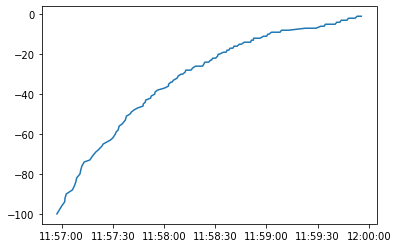

************************************ Simul number: 1


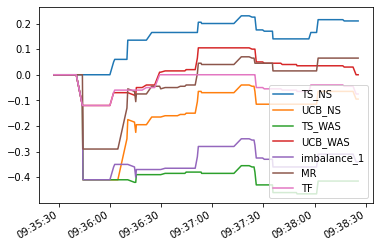

             count    mean       std    sharpe
oracle         2.0  0.3925  0.321734  1.219953
TS_NS          2.0  0.1050  0.148492  0.707107
MR             2.0  0.0425  0.031820  1.335646
UCB_WAS        2.0 -0.0175  0.024749 -0.707107
UCB_NS         2.0 -0.0425  0.074246 -0.572420
TF             2.0 -0.0925  0.024749 -3.737564
imbalance_1    2.0 -0.1750  0.233345 -0.749962
TS_WAS         2.0 -0.2200  0.275772 -0.797761
TS_NS : 9.01 bps
UCB_NS : -3.65 bps
TS_WAS : -18.88 bps
UCB_WAS : -1.5 bps


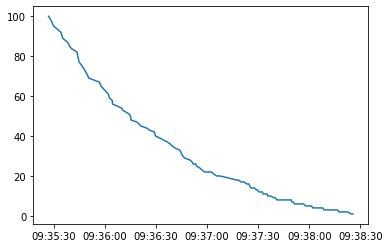

************************************ Simul number: 2


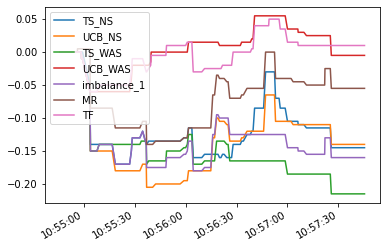

             count      mean       std    sharpe
oracle         3.0  0.391667  0.227505  1.721577
TS_NS          3.0  0.021667  0.178489  0.121389
MR             3.0  0.010000  0.060622  0.164957
UCB_WAS        3.0 -0.013333  0.018930 -0.704361
TF             3.0 -0.058333  0.061712 -0.945256
UCB_NS         3.0 -0.075000  0.076974 -0.974355
imbalance_1    3.0 -0.170000  0.165227 -1.028887
TS_WAS         3.0 -0.218333  0.195021 -1.119535
TS_NS : 1.83 bps
UCB_NS : -6.32 bps
TS_WAS : -18.39 bps
UCB_WAS : -1.12 bps


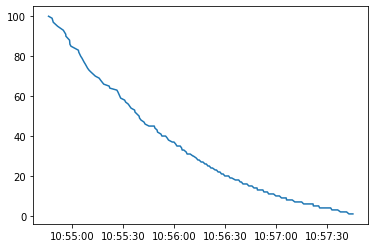

************************************ Simul number: 3


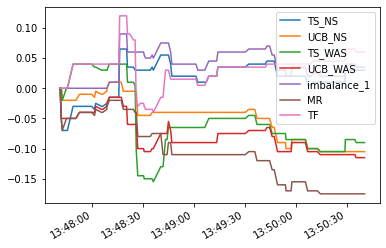

             count     mean       std    sharpe
oracle         4.0  0.38375  0.186430  2.058410
TS_NS          4.0  0.02375  0.145795  0.162900
TF             4.0 -0.02875  0.077715 -0.369943
MR             4.0 -0.03625  0.104911 -0.345532
UCB_WAS        4.0 -0.03875  0.053131 -0.729328
UCB_NS         4.0 -0.08250  0.064614 -1.276808
imbalance_1    4.0 -0.11875  0.169429 -0.700883
TS_WAS         4.0 -0.18625  0.171677 -1.084888
TS_NS : 1.98 bps
UCB_NS : -6.89 bps
TS_WAS : -15.56 bps
UCB_WAS : -3.24 bps


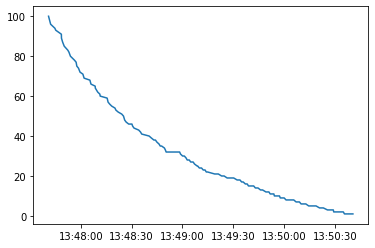

************************************ Simul number: 4


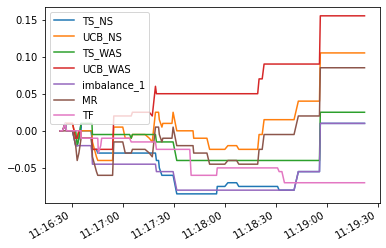

             count          mean       std        sharpe
oracle         5.0  3.700000e-01  0.164355  2.251227e+00
TS_NS          5.0  2.100000e-02  0.126412  1.661234e-01
UCB_WAS        5.0  2.842171e-15  0.098107  2.897009e-14
MR             5.0 -1.200000e-02  0.105806 -1.134147e-01
TF             5.0 -3.700000e-02  0.069785 -5.301970e-01
UCB_NS         5.0 -4.500000e-02  0.100809 -4.463877e-01
imbalance_1    5.0 -9.300000e-02  0.157623 -5.900155e-01
TS_WAS         5.0 -1.440000e-01  0.176153 -8.174696e-01
TS_NS : 1.78 bps
UCB_NS : -3.82 bps
TS_WAS : -12.21 bps
UCB_WAS : 0.0 bps


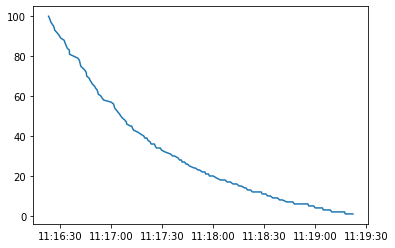

************************************ Simul number: 5


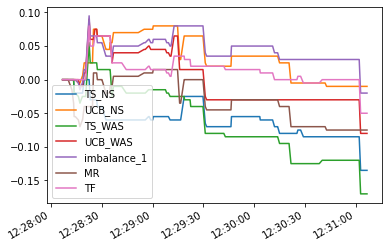

             count      mean       std    sharpe
oracle         6.0  0.359167  0.149379  2.404394
TS_NS          6.0 -0.005000  0.129769 -0.038530
UCB_WAS        6.0 -0.013333  0.093630 -0.142404
MR             6.0 -0.022500  0.098069 -0.229431
UCB_NS         6.0 -0.039167  0.091292 -0.429028
TF             6.0 -0.039167  0.062643 -0.625234
imbalance_1    6.0 -0.080833  0.144098 -0.560962
TS_WAS         6.0 -0.148333  0.157913 -0.939333
TS_NS : -0.42 bps
UCB_NS : -3.29 bps
TS_WAS : -12.46 bps
UCB_WAS : -1.12 bps


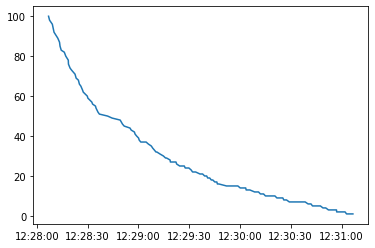

************************************ Simul number: 6


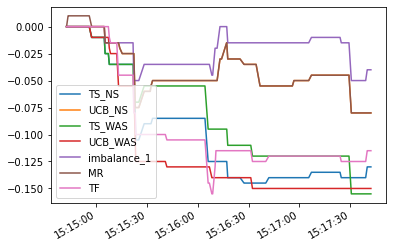

             count      mean       std    sharpe
oracle         7.0  0.327143  0.160542  2.037737
TS_NS          7.0 -0.022857  0.127536 -0.179221
MR             7.0 -0.030714  0.092124 -0.333400
UCB_WAS        7.0 -0.032857  0.099869 -0.329003
UCB_NS         7.0 -0.045000  0.084755 -0.530945
TF             7.0 -0.050000  0.063966 -0.781664
imbalance_1    7.0 -0.075000  0.132445 -0.566273
TS_WAS         7.0 -0.149286  0.144177 -1.035436
TS_NS : -1.91 bps
UCB_NS : -3.76 bps
TS_WAS : -12.46 bps
UCB_WAS : -2.74 bps


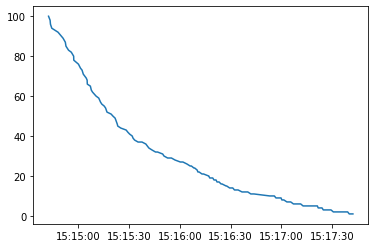

************************************ Simul number: 7


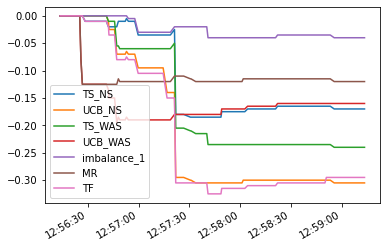

             count      mean       std    sharpe
oracle         8.0  0.293750  0.176104  1.668052
TS_NS          8.0 -0.041250  0.129028 -0.319698
MR             8.0 -0.041875  0.090945 -0.460443
UCB_WAS        8.0 -0.048750  0.102809 -0.474181
imbalance_1    8.0 -0.070625  0.123243 -0.573055
UCB_NS         8.0 -0.077500  0.120860 -0.641238
TF             8.0 -0.080625  0.104930 -0.768371
TS_WAS         8.0 -0.160625  0.137281 -1.170048
TS_NS : -3.46 bps
UCB_NS : -6.51 bps
TS_WAS : -13.49 bps
UCB_WAS : -4.09 bps


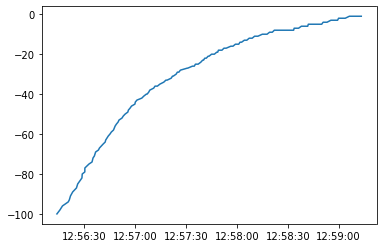

************************************ Simul number: 8


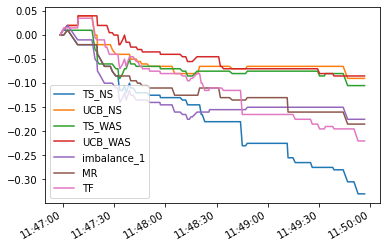

             count      mean       std    sharpe
oracle         9.0  0.275556  0.173538  1.587873
UCB_WAS        9.0 -0.052778  0.096925 -0.544522
MR             9.0 -0.057778  0.097536 -0.592376
TS_NS          9.0 -0.073333  0.154374 -0.475038
UCB_NS         9.0 -0.078889  0.113131 -0.697324
imbalance_1    9.0 -0.082222  0.120419 -0.682802
TF             9.0 -0.096111  0.108593 -0.885061
TS_WAS         9.0 -0.154444  0.129746 -1.190360
TS_NS : -6.19 bps
UCB_NS : -6.66 bps
TS_WAS : -13.04 bps
UCB_WAS : -4.46 bps


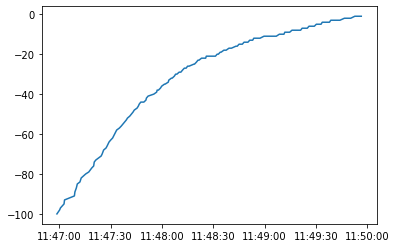

************************************ Simul number: 9


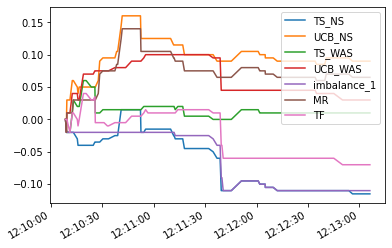

             count    mean       std    sharpe
oracle        10.0  0.2780  0.163795  1.697241
UCB_WAS       10.0 -0.0445  0.095057 -0.468140
MR            10.0 -0.0455  0.099818 -0.455830
UCB_NS        10.0 -0.0620  0.119285 -0.519764
TS_NS         10.0 -0.0775  0.146140 -0.530313
imbalance_1   10.0 -0.0850  0.113871 -0.746457
TF            10.0 -0.0935  0.102715 -0.910290
TS_WAS        10.0 -0.1380  0.132920 -1.038217
TS_NS : -6.51 bps
UCB_NS : -5.21 bps
TS_WAS : -11.59 bps
UCB_WAS : -3.74 bps


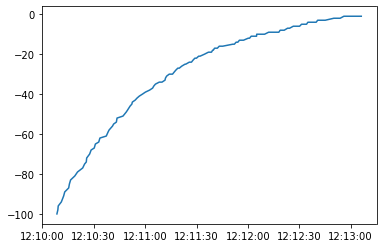

************************************ Simul number: 10


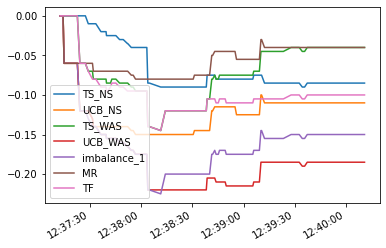

             count      mean       std    sharpe
oracle        11.0  0.264545  0.161670  1.636327
MR            11.0 -0.045000  0.094710 -0.475134
UCB_WAS       11.0 -0.057273  0.099633 -0.574835
UCB_NS        11.0 -0.066364  0.114085 -0.581702
TS_NS         11.0 -0.078182  0.138659 -0.563842
imbalance_1   11.0 -0.090909  0.109791 -0.828019
TF            11.0 -0.094091  0.097463 -0.965399
TS_WAS        11.0 -0.129091  0.129515 -0.996727
TS_NS : -6.57 bps
UCB_NS : -5.58 bps
TS_WAS : -10.85 bps
UCB_WAS : -4.81 bps


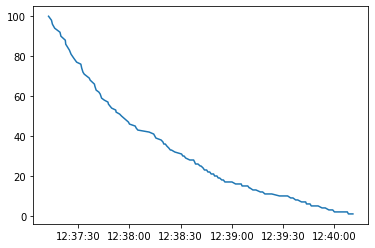

************************************ Simul number: 11


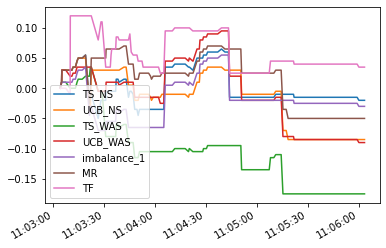

             count      mean       std    sharpe
oracle        12.0  0.287917  0.174114  1.653609
MR            12.0 -0.045417  0.090314 -0.502875
UCB_WAS       12.0 -0.060000  0.095465 -0.628500
UCB_NS        12.0 -0.067917  0.108909 -0.623609
TS_NS         12.0 -0.073333  0.133269 -0.550266
TF            12.0 -0.083333  0.100121 -0.832325
imbalance_1   12.0 -0.085833  0.106148 -0.808618
TS_WAS        12.0 -0.132917  0.124197 -1.070211
TS_NS : -6.21 bps
UCB_NS : -5.76 bps
TS_WAS : -11.26 bps
UCB_WAS : -5.08 bps


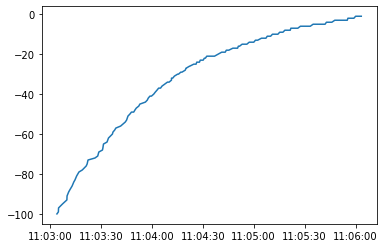

************************************ Simul number: 12


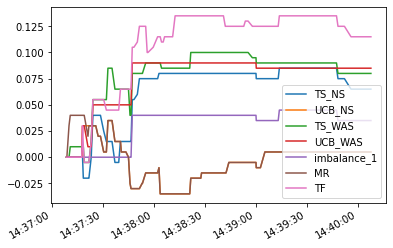

             count      mean       std    sharpe
oracle        13.0  0.294231  0.168249  1.748783
MR            13.0 -0.041538  0.087592 -0.474224
UCB_WAS       13.0 -0.048846  0.099857 -0.489160
UCB_NS        13.0 -0.062308  0.106215 -0.586616
TS_NS         13.0 -0.062692  0.133239 -0.470526
TF            13.0 -0.068077  0.110520 -0.615967
imbalance_1   13.0 -0.076538  0.107012 -0.715231
TS_WAS        13.0 -0.116538  0.132765 -0.877779
TS_NS : -5.24 bps
UCB_NS : -5.2 bps
TS_WAS : -9.73 bps
UCB_WAS : -4.08 bps


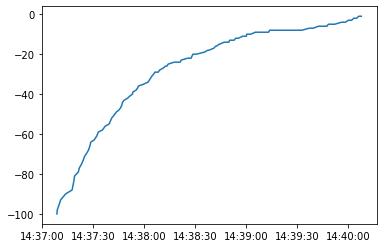

************************************ Simul number: 13


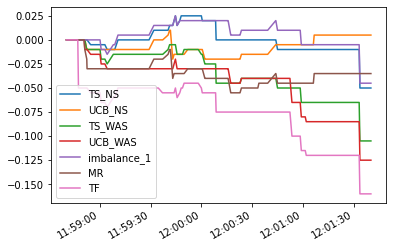

             count      mean       std    sharpe
oracle        14.0  0.280357  0.169779  1.651308
MR            14.0 -0.041071  0.084174 -0.487933
UCB_WAS       14.0 -0.054286  0.098075 -0.553513
UCB_NS        14.0 -0.057500  0.103622 -0.554902
TS_NS         14.0 -0.061786  0.128057 -0.482488
imbalance_1   14.0 -0.074286  0.103159 -0.720110
TF            14.0 -0.074643  0.108989 -0.684863
TS_WAS        14.0 -0.115714  0.127594 -0.906895
TS_NS : -5.21 bps
UCB_NS : -4.84 bps
TS_WAS : -9.75 bps
UCB_WAS : -4.57 bps


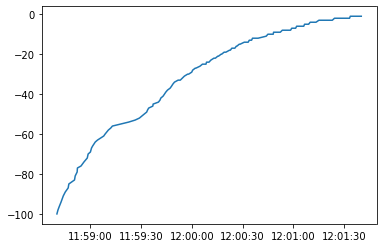

************************************ Simul number: 14


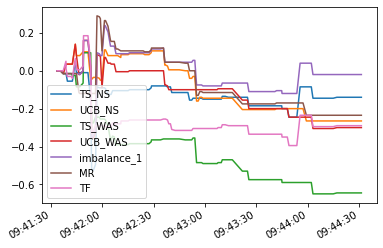

             count      mean       std    sharpe
oracle        15.0  0.343667  0.294767  1.165894
MR            15.0 -0.054000  0.095323 -0.566496
TS_NS         15.0 -0.067000  0.125040 -0.535829
UCB_WAS       15.0 -0.070667  0.113827 -0.620823
imbalance_1   15.0 -0.070667  0.100390 -0.703923
UCB_NS        15.0 -0.071333  0.113318 -0.629497
TF            15.0 -0.089000  0.118837 -0.748927
TS_WAS        15.0 -0.151000  0.183830 -0.821410
TS_NS : -5.75 bps
UCB_NS : -6.12 bps
TS_WAS : -12.96 bps
UCB_WAS : -6.07 bps


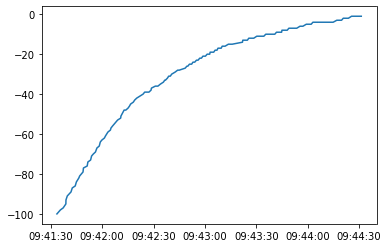

************************************ Simul number: 15


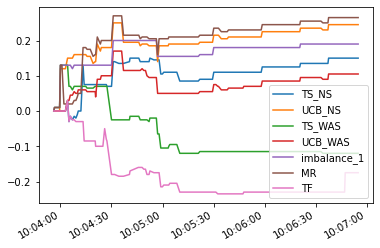

             count      mean       std    sharpe
oracle        16.0  0.369063  0.302348  1.220656
MR            16.0 -0.034063  0.121823 -0.279608
UCB_NS        16.0 -0.051562  0.135052 -0.381797
TS_NS         16.0 -0.053438  0.132423 -0.403538
imbalance_1   16.0 -0.054375  0.116846 -0.465357
UCB_WAS       16.0 -0.059687  0.118413 -0.504063
TF            16.0 -0.094375  0.116803 -0.807985
TS_WAS        16.0 -0.149063  0.177766 -0.838532
TS_NS : -4.51 bps
UCB_NS : -4.35 bps
TS_WAS : -12.58 bps
UCB_WAS : -5.04 bps


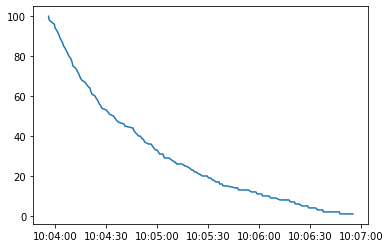

************************************ Simul number: 16


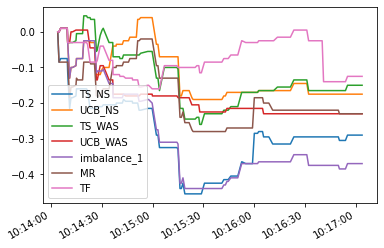

             count      mean       std    sharpe
oracle        17.0  0.385294  0.300299  1.283034
MR            17.0 -0.045588  0.127167 -0.358490
UCB_NS        17.0 -0.058824  0.134147 -0.438501
TS_NS         17.0 -0.067353  0.140469 -0.479485
UCB_WAS       17.0 -0.069706  0.121867 -0.571985
imbalance_1   17.0 -0.072941  0.136600 -0.533976
TF            17.0 -0.096176  0.113338 -0.848584
TS_WAS        17.0 -0.149118  0.172121 -0.866352
TS_NS : -5.68 bps
UCB_NS : -4.96 bps
TS_WAS : -12.58 bps
UCB_WAS : -5.88 bps


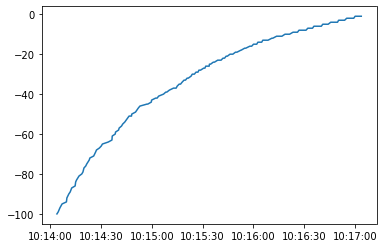

************************************ Simul number: 17


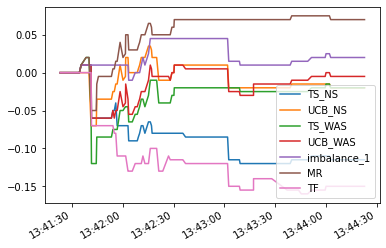

             count      mean       std    sharpe
oracle        18.0  0.379722  0.292291  1.299126
MR            18.0 -0.039167  0.126343 -0.310003
UCB_NS        18.0 -0.056667  0.130463 -0.434351
UCB_WAS       18.0 -0.066111  0.119208 -0.554588
imbalance_1   18.0 -0.067778  0.134320 -0.504600
TS_NS         18.0 -0.070000  0.136737 -0.511931
TF            18.0 -0.099167  0.110683 -0.895952
TS_WAS        18.0 -0.141944  0.169733 -0.836282
TS_NS : -5.85 bps
UCB_NS : -4.73 bps
TS_WAS : -11.86 bps
UCB_WAS : -5.52 bps


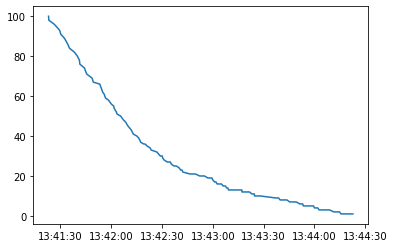

************************************ Simul number: 18


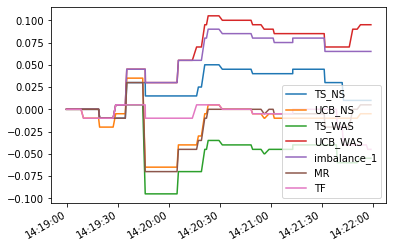

             count      mean       std    sharpe
oracle        19.0  0.368947  0.287912  1.281459
MR            19.0 -0.036842  0.123200 -0.299042
UCB_NS        19.0 -0.053947  0.127340 -0.423648
UCB_WAS       19.0 -0.057632  0.121602 -0.473935
imbalance_1   19.0 -0.060789  0.134043 -0.453509
TS_NS         19.0 -0.065789  0.134146 -0.490432
TF            19.0 -0.096316  0.108280 -0.889507
TS_WAS        19.0 -0.137368  0.166152 -0.826762
TS_NS : -5.49 bps
UCB_NS : -4.5 bps
TS_WAS : -11.46 bps
UCB_WAS : -4.81 bps


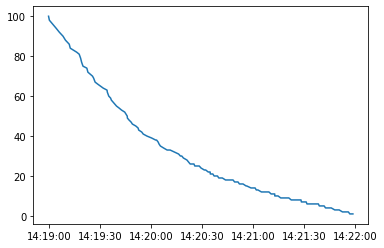

************************************ Simul number: 19


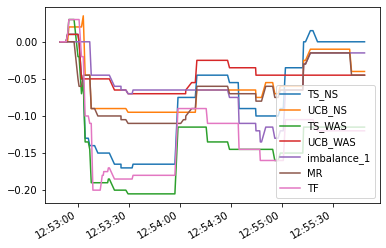

             count     mean       std    sharpe
oracle        20.0  0.36825  0.280250  1.314004
MR            20.0 -0.03725  0.119928 -0.310602
UCB_NS        20.0 -0.05325  0.123983 -0.429494
UCB_WAS       20.0 -0.05700  0.118393 -0.481448
imbalance_1   20.0 -0.05850  0.130869 -0.447013
TS_NS         20.0 -0.06250  0.131394 -0.475667
TF            20.0 -0.09750  0.105525 -0.923952
TS_WAS        20.0 -0.13625  0.161798 -0.842099
TS_NS : -5.26 bps
UCB_NS : -4.48 bps
TS_WAS : -11.47 bps
UCB_WAS : -4.8 bps


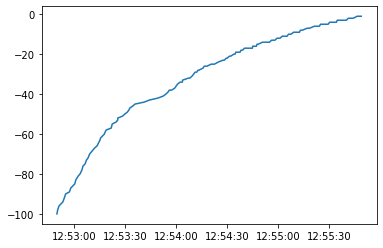

************************************ Simul number: 20


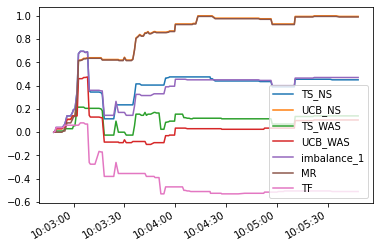

             count      mean       std    sharpe
oracle        21.0  0.423810  0.373413  1.134962
MR            21.0  0.011667  0.252811  0.046148
UCB_NS        21.0 -0.003333  0.258705 -0.012885
imbalance_1   21.0 -0.033333  0.171962 -0.193842
TS_NS         21.0 -0.038095  0.170026 -0.224056
UCB_WAS       21.0 -0.049286  0.120689 -0.408371
TF            21.0 -0.117143  0.136680 -0.857059
TS_WAS        21.0 -0.123095  0.168830 -0.729106
TS_NS : -3.22 bps
UCB_NS : -0.28 bps
TS_WAS : -10.39 bps
UCB_WAS : -4.16 bps


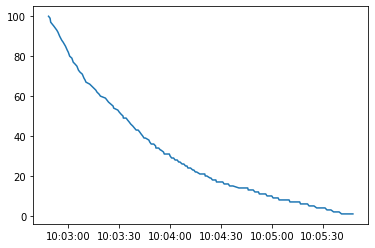

************************************ Simul number: 21


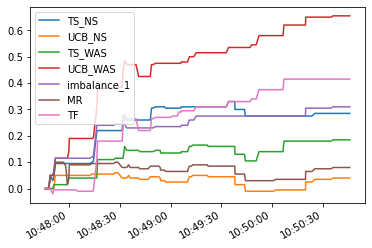

             count      mean       std    sharpe
oracle        22.0  0.440000  0.372242  1.182026
MR            22.0  0.014773  0.247148  0.059773
UCB_NS        22.0 -0.001364  0.252639 -0.005398
UCB_WAS       22.0 -0.017273  0.190836 -0.090511
imbalance_1   22.0 -0.017727  0.183087 -0.096824
TS_NS         22.0 -0.023409  0.179658 -0.130298
TF            22.0 -0.092955  0.175110 -0.530835
TS_WAS        22.0 -0.109091  0.177373 -0.615038
TS_NS : -1.97 bps
UCB_NS : -0.11 bps
TS_WAS : -9.17 bps
UCB_WAS : -1.45 bps


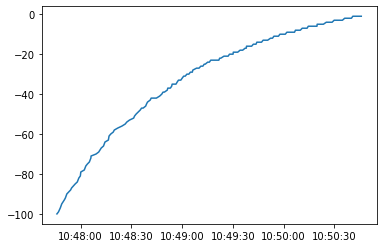

************************************ Simul number: 22


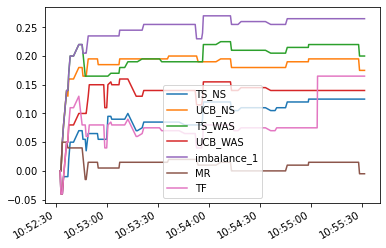

             count      mean       std    sharpe
oracle        23.0  0.443261  0.364020  1.217683
MR            23.0  0.013913  0.241501  0.057611
UCB_NS        23.0  0.006304  0.249555  0.025262
imbalance_1   23.0 -0.005435  0.188342 -0.028856
UCB_WAS       23.0 -0.010435  0.189310 -0.055120
TS_NS         23.0 -0.016957  0.178235 -0.095136
TF            23.0 -0.081739  0.179340 -0.455778
TS_WAS        23.0 -0.095652  0.184891 -0.517343
TS_NS : -1.43 bps
UCB_NS : 0.53 bps
TS_WAS : -8.05 bps
UCB_WAS : -0.88 bps


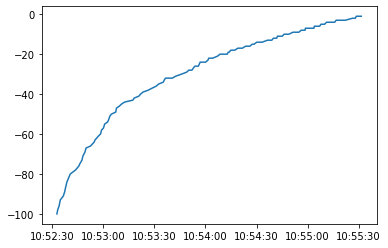

************************************ Simul number: 23


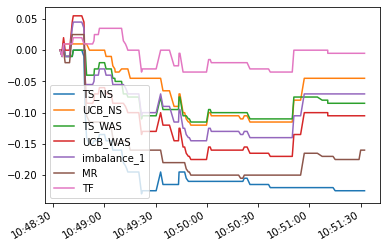

             count      mean       std    sharpe
oracle        24.0  0.436042  0.357771  1.218774
MR            24.0  0.006667  0.238845  0.027912
UCB_NS        24.0  0.004167  0.244294  0.017056
imbalance_1   24.0 -0.008125  0.184673 -0.043997
UCB_WAS       24.0 -0.014375  0.186153 -0.077222
TS_NS         24.0 -0.025625  0.179415 -0.142825
TF            24.0 -0.078542  0.176096 -0.446017
TS_WAS        24.0 -0.095208  0.180840 -0.526477
TS_NS : -2.16 bps
UCB_NS : 0.35 bps
TS_WAS : -8.01 bps
UCB_WAS : -1.21 bps


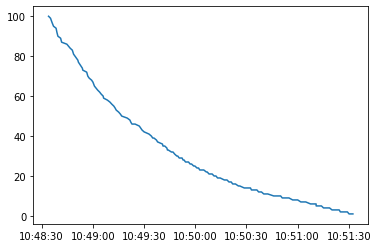

************************************ Simul number: 24


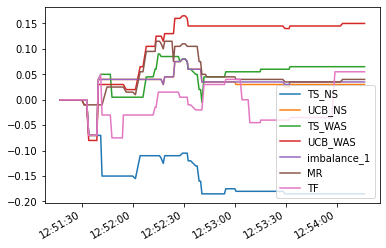

             count    mean       std    sharpe
oracle        25.0  0.4412  0.351186  1.256313
MR            25.0  0.0080  0.233911  0.034201
UCB_NS        25.0  0.0052  0.239207  0.021739
imbalance_1   25.0 -0.0064  0.180990 -0.035361
UCB_WAS       25.0 -0.0078  0.185175 -0.042122
TS_NS         25.0 -0.0320  0.178507 -0.179265
TF            25.0 -0.0732  0.174445 -0.419617
TS_WAS        25.0 -0.0888  0.179909 -0.493583
TS_NS : -2.69 bps
UCB_NS : 0.44 bps
TS_WAS : -7.48 bps
UCB_WAS : -0.66 bps


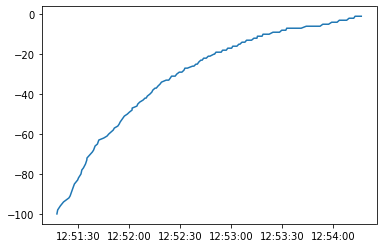

************************************ Simul number: 25


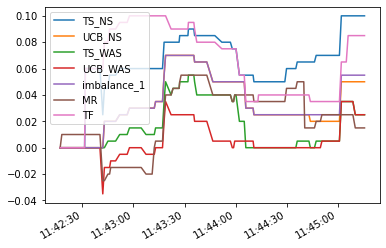

             count      mean       std    sharpe
oracle        26.0  0.435192  0.345452  1.259777
MR            26.0  0.008269  0.229190  0.036080
UCB_NS        26.0  0.006923  0.234538  0.029518
imbalance_1   26.0 -0.004038  0.177741 -0.022721
UCB_WAS       26.0 -0.006538  0.181548 -0.036015
TS_NS         26.0 -0.026923  0.176805 -0.152275
TF            26.0 -0.067115  0.173713 -0.386357
TS_WAS        26.0 -0.084423  0.177681 -0.475138
TS_NS : -2.28 bps
UCB_NS : 0.59 bps
TS_WAS : -7.14 bps
UCB_WAS : -0.55 bps


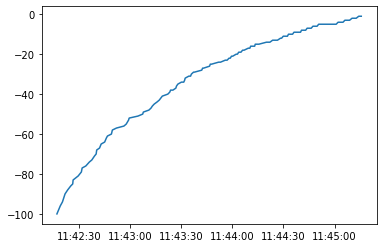

************************************ Simul number: 26


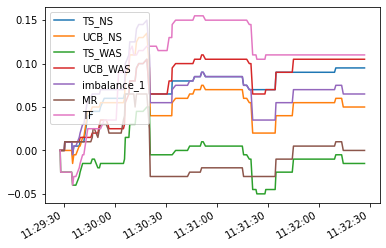

             count      mean       std    sharpe
oracle        27.0  0.432593  0.339013  1.276037
UCB_NS        27.0  0.008519  0.230133  0.037016
MR            27.0  0.007963  0.224745  0.035431
imbalance_1   27.0 -0.001481  0.174796 -0.008476
UCB_WAS       27.0 -0.002407  0.179312 -0.013426
TS_NS         27.0 -0.022407  0.174953 -0.128077
TF            27.0 -0.060556  0.173717 -0.348588
TS_WAS        27.0 -0.081852  0.174742 -0.468414
TS_NS : -1.9 bps
UCB_NS : 0.72 bps
TS_WAS : -6.93 bps
UCB_WAS : -0.2 bps


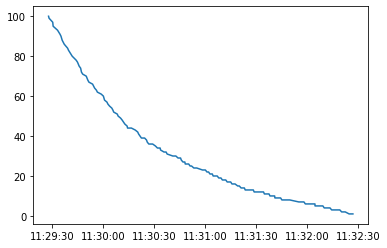

************************************ Simul number: 27


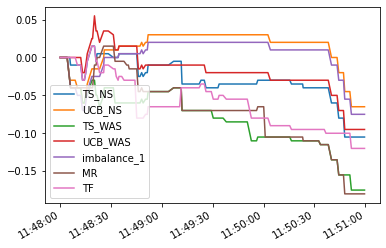

             count      mean       std    sharpe
oracle        28.0  0.423571  0.336083  1.260319
UCB_NS        28.0  0.005893  0.226258  0.026045
MR            28.0  0.001250  0.223386  0.005596
imbalance_1   28.0 -0.004107  0.172090 -0.023866
UCB_WAS       28.0 -0.005714  0.176828 -0.032316
TS_NS         28.0 -0.025357  0.172390 -0.147092
TF            28.0 -0.062679  0.170839 -0.366886
TS_WAS        28.0 -0.085179  0.172377 -0.494141
TS_NS : -2.14 bps
UCB_NS : 0.5 bps
TS_WAS : -7.19 bps
UCB_WAS : -0.48 bps


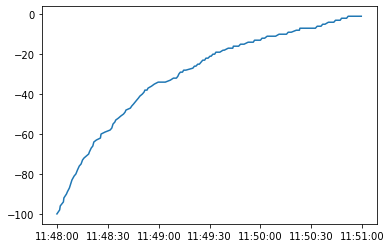

************************************ Simul number: 28


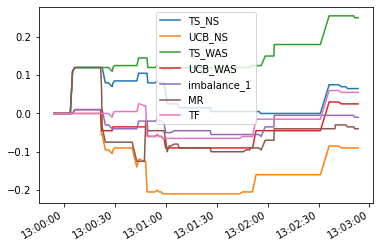

             count      mean       std    sharpe
oracle        29.0  0.425690  0.330224  1.289095
UCB_NS        29.0  0.002586  0.222893  0.011603
MR            29.0 -0.000172  0.219494 -0.000786
imbalance_1   29.0 -0.004310  0.168992 -0.025506
UCB_WAS       29.0 -0.004655  0.173735 -0.026795
TS_NS         29.0 -0.022241  0.170113 -0.130744
TF            29.0 -0.058621  0.169178 -0.346503
TS_WAS        29.0 -0.073621  0.180351 -0.408207
TS_NS : -1.86 bps
UCB_NS : 0.22 bps
TS_WAS : -6.17 bps
UCB_WAS : -0.39 bps


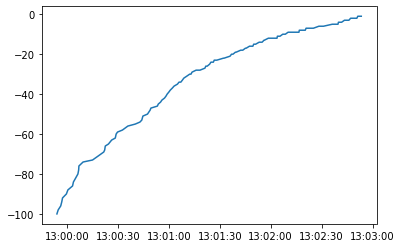

************************************ Simul number: 29


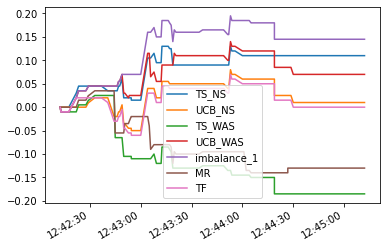

             count      mean       std    sharpe
oracle        30.0  0.422833  0.324857  1.301597
UCB_NS        30.0  0.002833  0.219021  0.012936
imbalance_1   30.0  0.000667  0.168276  0.003962
UCB_WAS       30.0 -0.002167  0.171256 -0.012652
MR            30.0 -0.004500  0.216975 -0.020740
TS_NS         30.0 -0.017833  0.168889 -0.105592
TF            30.0 -0.056667  0.166580 -0.340177
TS_WAS        30.0 -0.077333  0.178377 -0.433538
TS_NS : -1.5 bps
UCB_NS : 0.24 bps
TS_WAS : -6.5 bps
UCB_WAS : -0.18 bps


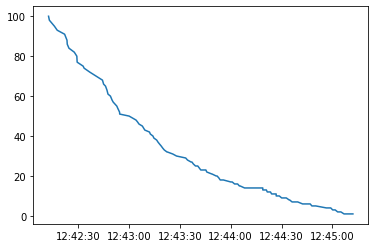

************************************ Simul number: 30


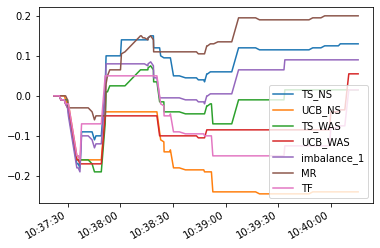

             count      mean       std    sharpe
oracle        31.0  0.431774  0.323253  1.335715
imbalance_1   31.0  0.003548  0.166224  0.021347
MR            31.0  0.002097  0.216467  0.009686
UCB_WAS       31.0 -0.000323  0.168691 -0.001912
UCB_NS        31.0 -0.005000  0.219712 -0.022757
TS_NS         31.0 -0.013065  0.168160 -0.077691
TF            31.0 -0.054355  0.164285 -0.330857
TS_WAS        31.0 -0.074355  0.176162 -0.422083
TS_NS : -1.1 bps
UCB_NS : -0.42 bps
TS_WAS : -6.25 bps
UCB_WAS : -0.03 bps


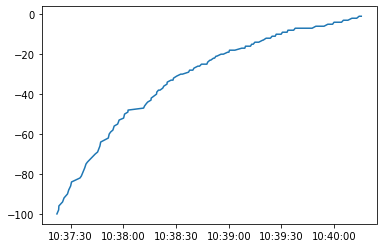

************************************ Simul number: 31


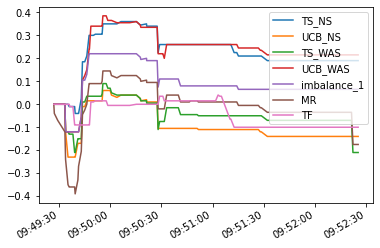

             count      mean       std    sharpe
oracle        32.0  0.442813  0.324069  1.366413
UCB_WAS       32.0  0.006406  0.170257  0.037627
imbalance_1   32.0  0.005469  0.163881  0.033370
MR            32.0 -0.003437  0.215236 -0.015971
TS_NS         32.0 -0.006719  0.169276 -0.039691
UCB_NS        32.0 -0.009219  0.217453 -0.042394
TF            32.0 -0.055781  0.161815 -0.344723
TS_WAS        32.0 -0.078594  0.174948 -0.449240
TS_NS : -0.57 bps
UCB_NS : -0.78 bps
TS_WAS : -6.69 bps
UCB_WAS : 0.54 bps


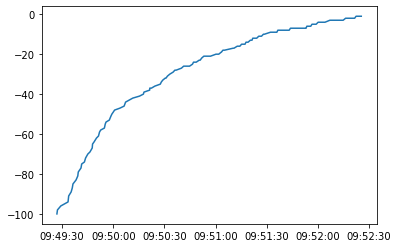

************************************ Simul number: 32


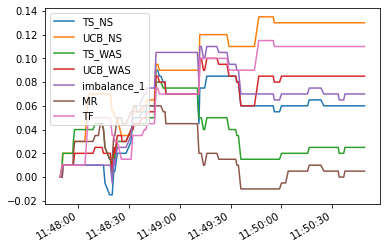

             count      mean       std    sharpe
oracle        33.0  0.438485  0.319933  1.370553
UCB_WAS       33.0  0.008788  0.168133  0.052267
imbalance_1   33.0  0.007424  0.161691  0.045916
MR            33.0 -0.003182  0.211851 -0.015019
TS_NS         33.0 -0.004697  0.167014 -0.028123
UCB_NS        33.0 -0.005000  0.215396 -0.023213
TF            33.0 -0.050758  0.161860 -0.313590
TS_WAS        33.0 -0.075455  0.173135 -0.435815
TS_NS : -0.4 bps
UCB_NS : -0.42 bps
TS_WAS : -6.37 bps
UCB_WAS : 0.74 bps


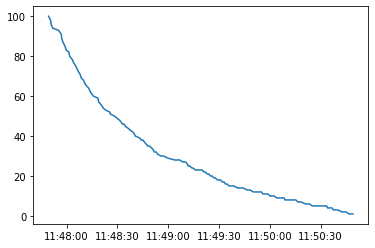

************************************ Simul number: 33


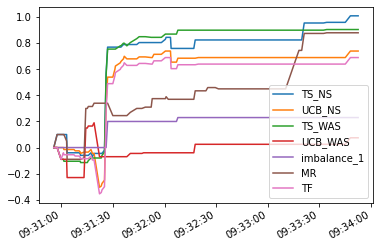

             count      mean       std    sharpe
oracle        34.0  0.496765  0.463398  1.072004
TS_NS         34.0  0.025147  0.239439  0.105025
MR            34.0  0.022794  0.257803  0.088417
UCB_NS        34.0  0.016912  0.247616  0.068298
imbalance_1   34.0  0.013971  0.163734  0.085325
UCB_WAS       34.0  0.010735  0.165955  0.064688
TF            34.0 -0.028971  0.203822 -0.142136
TS_WAS        34.0 -0.046618  0.239459 -0.194679
TS_NS : 2.15 bps
UCB_NS : 1.45 bps
TS_WAS : -3.99 bps
UCB_WAS : 0.92 bps


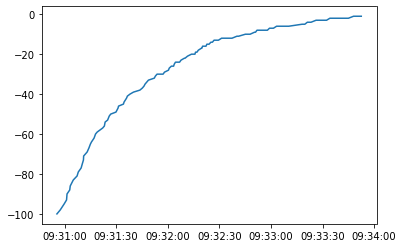

************************************ Simul number: 34


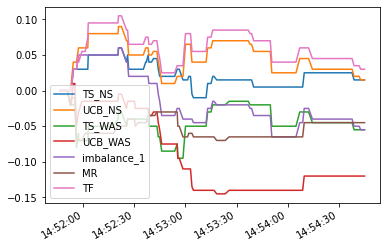

             count      mean       std    sharpe
oracle        35.0  0.491857  0.457455  1.075204
TS_NS         35.0  0.024857  0.235898  0.105373
MR            35.0  0.020857  0.254242  0.082037
UCB_NS        35.0  0.016857  0.243948  0.069101
imbalance_1   35.0  0.012000  0.161729  0.074198
UCB_WAS       35.0  0.007000  0.164983  0.042429
TF            35.0 -0.027286  0.201050 -0.135716
TS_WAS        35.0 -0.046857  0.235915 -0.198619
TS_NS : 2.08 bps
UCB_NS : 1.41 bps
TS_WAS : -3.91 bps
UCB_WAS : 0.58 bps


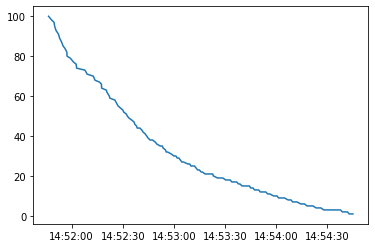

************************************ Simul number: 35


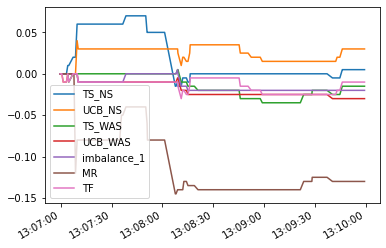

             count      mean       std    sharpe
oracle        36.0  0.483056  0.453954  1.064106
TS_NS         36.0  0.024306  0.232527  0.104528
UCB_NS        36.0  0.017222  0.240447  0.071626
MR            36.0  0.016667  0.251842  0.066179
imbalance_1   36.0  0.011111  0.159491  0.069666
UCB_WAS       36.0  0.005972  0.162726  0.036701
TF            36.0 -0.026806  0.198178 -0.135260
TS_WAS        36.0 -0.045972  0.232581 -0.197661
TS_NS : 2.04 bps
UCB_NS : 1.44 bps
TS_WAS : -3.85 bps
UCB_WAS : 0.5 bps


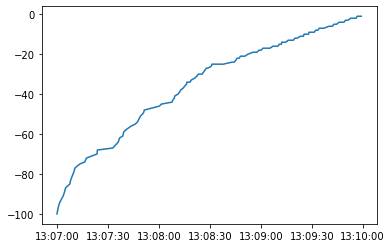

************************************ Simul number: 36


KeyboardInterrupt: 

In [28]:
nb_simulations    = 200
res_simulations   = {}
programme_horizon = '3min'

for i_simul in range(nb_simulations):
    print('************************************ Simul number:', i_simul)
    
    # choose a random starting point for the programme starting time
    i_start = int(np.random.rand(1)*(9*len(all_data)/10))
    programme_data = all_data.iloc[i_start:].first(programme_horizon)
    
    # Fill na exec prices accordingly
    for col in programme_data.columns:
        if 'Price_' in col:
            programme_data[col].fillna(programme_data[ref_price], inplace=True)

    bandit_rewards, bandits_fin_info, batch_times = init_variables(programme_data, bandits)
    
    buysell          = 2*np.random.randint(0, 2, size=None, dtype=int)-1
    verbose_print(verbose_level, None, f'I received an order at {None} with quantity {buysell}', True)
    
    q0     = 100*buysell
    q      = np.zeros(len(batch_times)+1)
    q[0]   = q0
    dt     = T/len(batch_times)
    
    for (i_time, batch_time) in enumerate(batch_times): # leave a few minutes
        # if np.random.poisson(arrival_intensity)>0:
        sigma       = 5
        q_cible     = q_star(T * i_time/len(batch_times), q0, T, 10**-3, sigma, V, nu, dt)
        trade_size  = int(q_cible - q[i_time])     
        q[i_time+1] = q[i_time]+trade_size
        
        V           = 15000000 #TransactionTape.set_index('time').traded_quantity.rolling('1h').sum().mean()
        nu          = 0.1
        nb_orders   += 1
        
#             if ((nb_orders%20==0) & (i_time>0)):
#                 print('************************************ Simul number:', i_simul)
#                 clear_output(wait=True)
#                 verbose_level = 1
#                 for bandit_k in bandits.keys():
#                     bandits[bandit_k].plot_strategies()         

#                 # get historical rewards and regret
#                 rewards_to_plot = pd.DataFrame(index=programme_data.index)
#                 for bandit_k in bandits.keys():
#                     rewards_to_plot[bandit_k] = np.array(bandit_rewards[bandit_k])
#                 for (i_strat, strat) in enumerate(strategies.keys()):
#                     rewards_to_plot[strat]    = np.array(bandit_rewards[strat])
#                 rewards_to_plot = rewards_to_plot.sort_index()
#                 regret_plots(strategies, rewards_to_plot.dropna(), programme_data,  bandits, W=5.5, figure_name = None)
#             else:
#                 verbose_level = 0

        trade_date = str(batch_time).split(' ')[0]

        ###############################################
        # retrain GPs hyperparameters every N orders 
        ###############################################
        retrain_hyperparameters = True

        ##################################################
        # if an order arrives: decide if buy & sell
        ##################################################
        i_order          += 1

        ######################
        # get feature values
        ######################
        feature_values = features.loc[batch_time, :]

        ######################################
        # select the strategy for all bandits
        ######################################
        verbose_print(verbose_level, batch_time, f'Selecting strategies ...')
        best_strategies_bandits = {}
        for bandit_k in bandits.keys():
            verbose_print(verbose_level, batch_time, f'** Bandit {bandit_k}: Selecting strategies ...')
            if i_time < 5*len(strategies): # at least 5 rewards before sampling
                best_strategies_bandits[bandit_k]  = random.choice(list(strategies.keys()))
            else:
                best_strategies_bandits[bandit_k]  = bandits[bandit_k].select_best_strategy(feature_values)
            verbose_print(verbose_level, batch_time, f'Selected strategy: {best_strategies_bandits[bandit_k]}')

        ######################################
        # Update & Retrain the GPs
        # & Non stationarity test
        ######################################
        tmp_pnls = {bandit_k:np.nan for bandit_k in bandits.keys()}
        for bandit_k in bandits.keys():
            if buysell == 1:
                tmp_pnls[bandit_k] = -programme_data.loc[batch_time, f'buyPrice_{best_strategies_bandits[bandit_k]}'] + \
                            programme_data.loc[batch_time, ref_price]
            else:
                tmp_pnls[bandit_k] = programme_data.loc[batch_time, f'sellPrice_{best_strategies_bandits[bandit_k]}'] - \
                            programme_data.loc[batch_time, ref_price]

        for bandit_k in bandits.keys():
            # print('Adding: ', feature_values, best_strategies_bandits[bandit_k], tmp_pnls[bandit_k])
            bandits[bandit_k].update_data(features  = feature_values, 
                                          strat     = best_strategies_bandits[bandit_k], 
                                          reward    = tmp_pnls[bandit_k],
                                          retrain_hyperparameters = retrain_hyperparameters)

        ######################################
        # Record rewards
        ######################################
        for bandit_k in bandits.keys():
            if buysell == 1:
                bandits_fin_info[bandit_k].loc[batch_time,'execPrice']  = \
                                programme_data.loc[batch_time, f'buyPrice_{best_strategies_bandits[bandit_k]}'] 
            else:
                bandits_fin_info[bandit_k].loc[batch_time,'execPrice']  = \
                                programme_data.loc[batch_time, f'sellPrice_{best_strategies_bandits[bandit_k]}'] 

            bandit_rewards.loc[batch_time, bandit_k]               = tmp_pnls[bandit_k]
            bandits_fin_info[bandit_k].loc[batch_time,'S0']        = programme_data.loc[batch_time, 'S0'] 
            bandits_fin_info[bandit_k].loc[batch_time,'ST']        = programme_data.loc[batch_time, 'ST'] 
            bandits_fin_info[bandit_k].loc[batch_time,'twapPrice'] = programme_data.loc[batch_time, 'twapPrice'] 

        for strat in strategies.keys():
            if buysell == 1:
                bandit_rewards.loc[batch_time, strat] = \
                            -programme_data.loc[batch_time, f'buyPrice_{strat}'] + \
                            programme_data.loc[batch_time, ref_price]
            else:
                bandit_rewards.loc[batch_time, strat] = \
                            programme_data.loc[batch_time, f'sellPrice_{strat}'] - \
                            programme_data.loc[batch_time, ref_price]


        ##############################
        # Record oracle info
        ##############################
        oracle_strategy = bandit_rewards.loc[batch_time, strategies.keys()].idxmax() #(pnls_buy.loc[batch_time]).idxmax()
        bandit_rewards.loc[batch_time, 'oracle'] = bandit_rewards.loc[batch_time, f'{oracle_strategy}']
        verbose_print(verbose_level, batch_time, f"Oracle strategy: {oracle_strategy}")
    
    # multiply pnls by trading speed
    v = np.diff(q)
    for i in range(len(bandit_rewards)):
        bandit_rewards.iloc[i,:] = np.abs(v[i]) * bandit_rewards.iloc[i,:]

    res_simulations[i_simul] = buysell, bandit_rewards, bandits_fin_info, q
    
    # see regrets & rewards
    rewards_to_plot = pd.DataFrame(index=programme_data.index)
    for bandit_k in bandits.keys():
        rewards_to_plot[bandit_k] = np.array(bandit_rewards[bandit_k])
    for (i_strat, strat) in enumerate(strategies.keys()):
        rewards_to_plot[strat]    = np.array(bandit_rewards[strat])
    rewards_to_plot = rewards_to_plot.sort_index()
    rewards_to_plot.dropna().cumsum().plot()
    plt.show()
    
    df_sim_results = pd.concat( (res_simulations[i][1].dropna().cumsum().iloc[-1] for i in res_simulations.keys()), axis=1).T
    stats_sim = df_sim_results.describe().T
    stats_sim['sharpe'] = stats_sim['mean']/stats_sim['std']
    
    # Some printing
    print(stats_sim.sort_values(by='mean', ascending=False).loc[:, ['count', 'mean', 'std', 'sharpe']])
    for bandit_k in bandits.keys():
        print( bandit_k, ':', round(10000 * stats_sim.loc[bandit_k, 'mean']/bandits_fin_info[bandit_k].execPrice.mean(), 2), "bps" )
    plt.plot(res_simulations[i_simul][1].dropna().index, q[1:]) #np.linspace(len(res_simulations[i_simul][1].dropna()), 0, len(res_simulations[i_simul][1].dropna()))
    plt.show()
    # regret_plots(strategies, rewards_to_plot.dropna(), programme_data,  bandits, W=5.5, figure_name = None)

In [ ]:
for bandit_k in bandits.keys():
    print( bandit_k, ':', round(10000 * stats_sim.loc[bandit_k, 'mean']/bandits_fin_info[bandit_k].execPrice.mean(), 2), "bps" )

In [ ]:
# rewards_to_plot

In [ ]:
# programme_data

In [ ]:
# plt.plot(res_simulations[i_simul][1].dropna().index, q[1:])

In [ ]:
df_sim_results = pd.concat( (res_simulations[i][1].dropna().cumsum().iloc[-1] for i in res_simulations.keys()), axis=1).T
stats_sim = df_sim_results.describe().T
stats_sim['sharpe'] = stats_sim['mean']/stats_sim['std']
print(stats_sim.sort_values(by='mean', ascending=False).loc[:, ['count', 'mean', 'std', 'sharpe']])

In [ ]:
# res_simulations[i][2][bandit_k]
# df_sim_results
# df_sim_results

In [ ]:
df_sim_results = pd.concat( (res_simulations[i][1].dropna().cumsum().iloc[-1] for i in res_simulations.keys()), axis=1).T
stats_sim = df_sim_results.describe().T
stats_sim['sharpe'] = stats_sim['mean']/stats_sim['std']

stats_sim.sort_values(by='mean', ascending=False).loc[:, ['count', 'mean', 'std', 'sharpe']]

In [ ]:
# res_simulations[i][2][bandit_k].dropna()

In [ ]:
# rewards_to_plot.dropna().cumsum().plot()

In [ ]:
# i=0
# res_simulations[i][1][bandit_k].dropna()
res_simulations[i][1][bandit_k]

In [ ]:
bench    = 'twapPrice'

for bandit_k in bandits.keys():
    print('\n', '***********', bandit_k, '***********')
    pnl_bandit = 0
    pnl_twap   = 0
    pnl_execS0 = 0
    pnl_execST = 0
    n          = len(res_simulations)
    
    for i in range(n):
        tmp_bandit   = res_simulations[i][2][bandit_k].dropna()
        pnl_bandit   += tmp_bandit.execPrice.sum() - tmp_bandit[bench].sum()
        # pnl_twap     += tmp_bandit.twapPrice.sum() - len(tmp_bandit)*tmp_bandit.iloc[0][bench]
        # pnl_execS0   += tmp_bandit.S0.sum()        - len(tmp_bandit)*tmp_bandit.iloc[0][bench]
        # pnl_execST   += tmp_bandit.ST.sum()        - len(tmp_bandit)*tmp_bandit.iloc[0][bench]

    print('PNL:', pnl_bandit/n)
# res_simulations[i][1]['TS_WAS'].dropna().S0.sum()

In [ ]:
# fig, axes = plt.subplots(2, 3, sharey=True)
# for (i_i, bandit_k) in enumerate(bandits.keys()):
#     for (i_j, strat) in enumerate(strategies):
#         axes[i_i, i_j].plot(distances[bandit_k][strat])
#         axes[i_i, i_j].set_title(f'bandit {bandit_k}\n strat {strat}')
#         axes[i_i, i_j].grid(axis='both')
# plt.tight_layout()

# Regret analysis

In [ ]:
# get historical rewards and regret
rewards_to_plot = pd.DataFrame(index=all_data.index)
regrets_to_plot = pd.DataFrame(index=all_data.index)

for bandit_k in bandits.keys():
    regrets_to_plot[bandit_k] = - np.array(bandit_rewards[bandit_k]) + np.array(bandit_rewards['oracle'])
for (i_strat, strat) in enumerate(strategies.keys()):
    regrets_to_plot[strat]    = - np.array(bandit_rewards[strat]) + np.array(bandit_rewards['oracle'])

for bandit_k in bandits.keys():
    rewards_to_plot[bandit_k] = np.array(bandit_rewards[bandit_k])
for (i_strat, strat) in enumerate(strategies.keys()):
    rewards_to_plot[strat]    = np.array(bandit_rewards[strat])

regrets_to_plot = regrets_to_plot.sort_index()
rewards_to_plot = rewards_to_plot.sort_index()

### Hit ratio

In [ ]:
# (bandit_rewards.dropna()['UCB']==bandit_rewards.dropna()['oracle']).sum()/len(bandit_rewards.dropna())

In [ ]:
hit_ratio_analysis(rewards_to_plot, bandit_rewards['oracle'], bandits, _W = 5.5)

### Reward distributions

In [ ]:
for (clr, bandit_k) in zip(('k', 'tan', 'blue'), bandits.keys()):
    rewards_to_plot[bandit_k].hist(bins=30,  color=clr, alpha=0.4, density=True)

plt.legend(bandits.keys())

### Reward distributions in time

In [ ]:
period_est  = 20 # in number of rewards, can be "10min"
bandit_name = 'TS_WAS'

reward_distribution_analysis(bandit_name, bandits, period_est, all_data, rewards_to_plot.dropna(), bandit_rewards.dropna(),
                              strategies, W = 7, figure_name = None)

### Regret plots

In [ ]:
regret_plots(strategies, regrets_to_plot.dropna(), all_data,  bandits, W=5.5, figure_name = None)

In [ ]:
regret_plots(strategies, rewards_to_plot.dropna(), all_data,  bandits, W=5.5, figure_name = None)

### GP plot

In [ ]:
bandit_name  = 'TS_WAS'
bandits[bandit_name].plot_strategies()

In [ ]:
bandit_name  = 'UCB_WAS'
bandits[bandit_name].plot_strategies()

In [ ]:
rewards_to_plot